<a href="https://colab.research.google.com/github/hirokimituya/stock-price-analysis/blob/main/technical_analysis/%E6%A0%AA%E4%BE%A1%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 3.6 MB/s eta 0:00:00


In [2]:
# Ta-Libをインストールしてimportしようとするとエラーとなるため、代わりにpandas_taを使用している
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib

In [3]:
# Ta-Libの代替としてpandas_taを利用している。Ta-Libの関数名を小文字にしたものがあるイメージ
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218921 sha256=6c70886feceaa326f768d2b9c730609236ef8e90c3c607e51d1a307bb05f0d38
  Stored in directory: /root/.cache/pip/wheels/1e/5c/47/759b32beb377aee150eb4c1f1b2b7635032cc19ea09ce076fd
Successfully built pandas_ta


In [4]:
import pandas_datareader.data as pdr

# 株価データを取得するメソッド
def get_stock_data(code):
    """株価データを取得する

    :param code: 取得する株価データの銘柄コード
    :return: 株価データのデータフレーム
    """
    df = pdr.DataReader(f'{code}.JP', 'stooq').sort_index()
    return df

<Axes: xlabel='Date'>

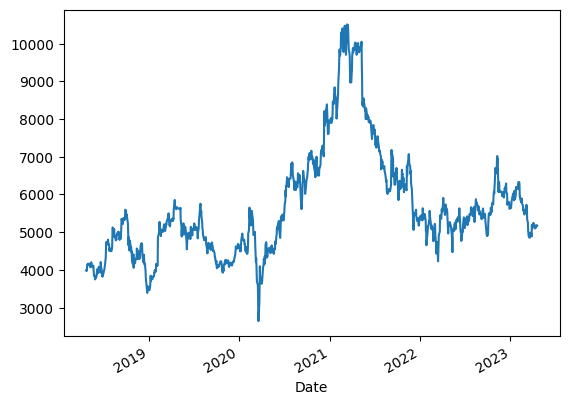

In [5]:
# ソフトバンクの株価データ取得
df = get_stock_data(9984)
df['Close'].plot()

### 高値と安値で差が大きいデータが多いほど、短期間での売買で利益を出しやすい銘柄であると判断できる

In [6]:
# 高値と安値の差が300円以上の株価データ
df.query('High - Low >= 300').tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-11-08,6655.0,6997.0,6650.0,6929.0,33680300.0
2022-11-14,6353.0,6453.0,5956.0,6068.0,40860800.0
2022-11-16,6090.0,6400.0,6090.0,6328.0,32497500.0
2022-11-18,6355.0,6363.0,6044.0,6075.0,25586100.0
2022-12-20,6038.0,6041.0,5715.0,5726.0,16122200.0


### テクニカル指標をチャートに描画する

In [69]:
import pandas_ta as ta
import mplfinance as mpf
import matplotlib
import datetime as dt

# ローソク足と出来高を表示するメソッド
def show_plot(code, start, end, sma=[], bbands={}, show_volume=True, width=2, height=1, period=None):
    """ローソク足や移動平均線のチャートを表示する

    :param code: 取得する株価データの銘柄コード
    :param start: 取得する株価データの開始日
    :param end: 取得する株価データの終了日
    :param sma: チャートに移動平均線を表示するためのリスト（例: [5, 25, 75]）
    :param bbands: チャートにボリンジャーバンドを表示するための辞書（例: {'sma': 25, 'bbands': [1, 2]}）
    :param show_volume: チャートに出来高を表示するかどうかのブール値
    :param width: チャートの幅（縦横比）
    :param height: チャートの高さ（縦横比）
    :param period: 表示するチャートの期間をどの単位でまとめるか（'W' or 'M'）
    """
    # 株価データの取得
    df = get_stock_data(code)
    close = df['Close']

    # 月足、周足にリサンプリング
    if period in ('M', 'W'):
        resampled = df.resample(period)
        df = resampled.aggregate({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
    
    # ①移動平均線の算出
    for ma in sma:
        df[f'ma{ma}'] = ta.sma(close, ma)

    # ②ボリンジャーバンドの算出
    if bbands:
        df[f'ma{bbands["sma"]}'] = ta.sma(close, bbands['sma'])
        for n in bbands['bbands']:
            bbdf = ta.bbands(close, length=bbands["sma"], std=n)
            df[f'upper{n}'], df[f'lower{n}'] = bbdf.iloc[:, 2], bbdf.iloc[:, 0]

    # 日付で絞り込み
    cdf = df[start:end]

    # チャートに表示するために使用する変数
    colors = ['blue', 'green', 'red']
    apd = []
    labels = []

    # ①移動平均線をチャートに表示するための準備（合わせてチャートに表示するラベル名のリストも作成する）
    for ma, color in zip(sma, colors):
        apd.append(mpf.make_addplot(cdf[f'ma{ma}'], color=color, width=0.8))
        labels.append(f'ma{ma}'.upper())
    
    # ②ボリンジャーバンドをチャートに表示するための準備（合わせてチャートに表示するラベル名のリストも作成する）
    if bbands:
        apd.append(mpf.make_addplot(cdf[f'ma{bbands["sma"]}'], color=colors[0], width=0.5))
        labels.append(f'ma{bbands["sma"]}'.upper())
        for n in bbands['bbands']:
            apd.append(mpf.make_addplot(cdf[f'upper{n}'], color=colors[n], width=0.5))
            apd.append(mpf.make_addplot(cdf[f'lower{n}'], color=colors[n], width=0.5))
            labels.extend([f'+{n}σ', f'−{n}σ'])

    # 描画情報を取得
    fig, axes = mpf.plot(cdf, type='candle', figratio=(width, height), volume=show_volume, style='yahoo', addplot=apd, returnfig=True, datetime_format="%Y/%m/%d")

    # 数値に「,」をつける
    axes[0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    # ラベルを追加
    if labels:
        axes[0].legend([None] * (len(labels) + 2))
        handles = axes[0].get_legend().legend_handles
        axes[0].legend(handles=handles[2:], labels=labels)

    # チャートを表示
    fig.show()

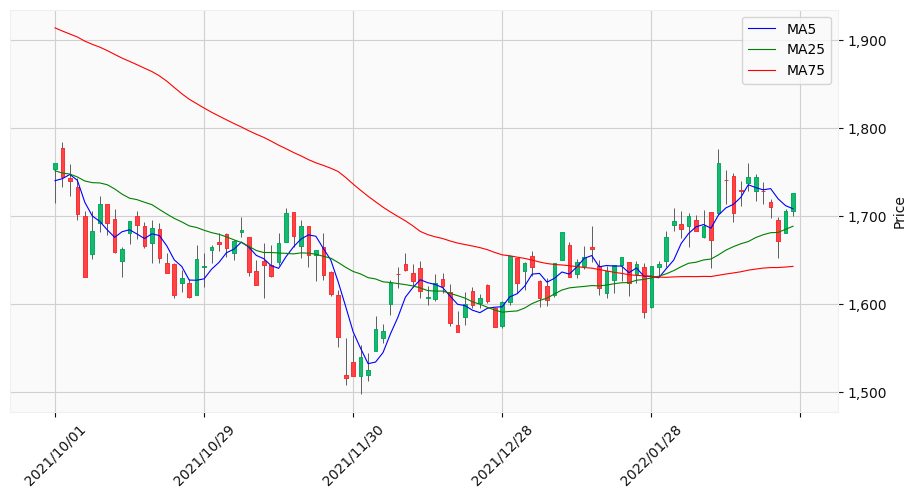

In [74]:
# 移動平均線をチャートに表示する
show_plot(7616, '2021-10-1', '2022-2-28', sma=[5, 25, 75], show_volume=False)

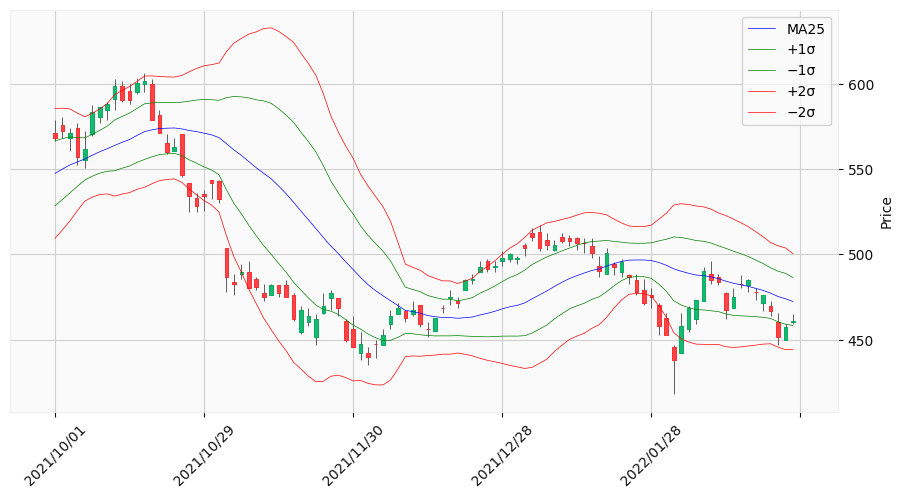

In [75]:
# ボリンジャーバンドをチャートに表示する
show_plot(4902, '2021-10-1', '2022-2-28', bbands={'sma': 25, 'bbands': [1, 2]}, show_volume=False)